# MODELO FORECAST UNIVARIADO SERIES DE TIEMPO USDPEN


In [109]:
# 1. Configuración inicial y carga de datos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from darts import TimeSeries
from darts.models import NBEATSModel, AutoARIMA, NHiTSModel, TiDEModel, TSMixerModel, Prophet
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.metrics import mae, mape
from darts.dataprocessing.transformers import Scaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from catboost import CatBoostRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
import optuna
import json
from typing import Optional
from datetime import datetime
import pickle
import os
from tqdm import tqdm

In [110]:
# Download data from YFinance monthly

#PEN_YF = yf.download("PEN=X",start = test_dates[0], end = test_dates[-1], interval = "1mo")

In [111]:
import logging

# Establece el nivel de logging
logging.getLogger("pytorch_lightning").setLevel(logging.ERROR)

In [112]:
# Cargar datos
df = pd.read_csv('monthly_data.csv')
df['DATES'] = pd.to_datetime(df['DATES'])
df.set_index('DATES', inplace=True)

df = df.dropna()
df.head(), df.tail()

C:\Users\Carlos Palma\AppData\Local\Temp\ipykernel_13536\2008386010.py:3: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['DATES'] = pd.to_datetime(df['DATES'])


(              PEN
 DATES            
 1994-12-31  2.185
 1995-01-31  2.194
 1995-02-28  2.237
 1995-03-31  2.258
 1995-04-30  2.245,
                PEN
 DATES             
 2024-04-30  3.7664
 2024-05-31  3.7245
 2024-06-30  3.8425
 2024-07-31  3.7283
 2024-08-31  3.7493)

In [113]:
# Preprocesamiento de datos
series = TimeSeries.from_dataframe(df[['PEN']])
train_size = int(len(series) * 0.8)
train, test = series[:train_size], series[train_size:]

In [114]:

test_dates = test.time_index 
train_dates = train.time_index
#Last date of test_date
last_train_date = train_dates[-1]
first_test_date = test_dates[0]
# value of df[PEN] in last_train_date
last_train_value = df['PEN'][last_train_date]
last_train_value


3.2878

In [115]:
PEN_TEST = df.loc[test_dates, 'PEN']
PEN_TEST

DATES
2018-09-30    3.3040
2018-10-31    3.3715
2018-11-30    3.3830
2018-12-31    3.3685
2019-01-31    3.3275
               ...  
2024-04-30    3.7664
2024-05-31    3.7245
2024-06-30    3.8425
2024-07-31    3.7283
2024-08-31    3.7493
Name: PEN, Length: 72, dtype: float64

In [116]:
# Analisis de la serie train
df_train = train.pd_dataframe()

In [117]:
print(df_train.describe())

component         PEN
count      285.000000
mean         3.062282
std          0.365227
min          2.185000
25%          2.794500
50%          3.166000
75%          3.375000
max          3.632000


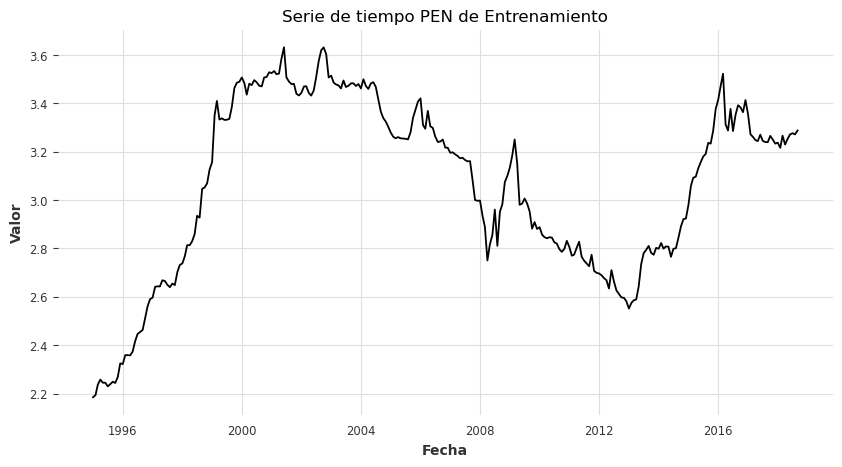

In [118]:
plt.figure(figsize=(10, 5))
plt.plot(df_train)
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.title('Serie de tiempo PEN de Entrenamiento') 
plt.show()


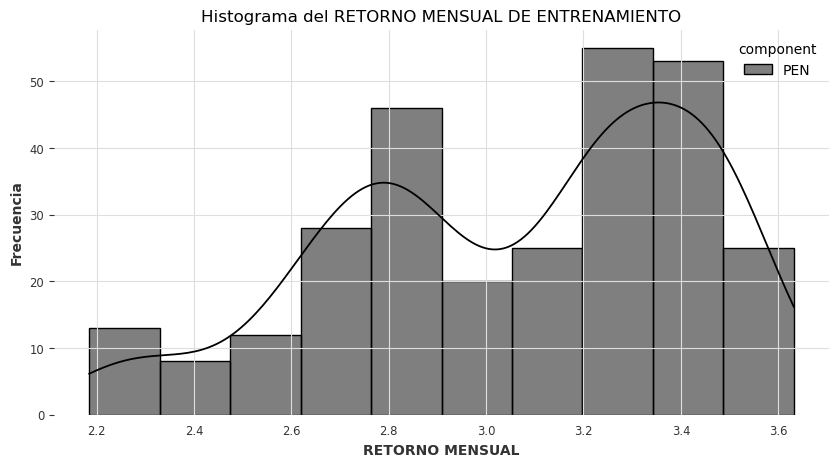

In [119]:
plt.figure(figsize=(10, 5))
sns.histplot(df_train, kde=True)  # Ajusta 'valor' al nombre de la columna de la serie de tiempo
plt.title('Histograma del RETORNO MENSUAL DE ENTRENAMIENTO')
plt.xlabel('RETORNO MENSUAL')
plt.ylabel('Frecuencia')
plt.show()

In [120]:
q1 = df_train.quantile(0.25)
q2 = df_train.quantile(0.50)  # Esto es equivalente a la mediana
q3 = df_train.quantile(0.75)

print(f"Primer cuartil (Q1): {q1}")
print(f"Mediana (Q2): {q2}")
print(f"Tercer cuartil (Q3): {q3}")

Primer cuartil (Q1): component
PEN    2.7945
Name: 0.25, dtype: float64
Mediana (Q2): component
PEN    3.166
Name: 0.5, dtype: float64
Tercer cuartil (Q3): component
PEN    3.375
Name: 0.75, dtype: float64


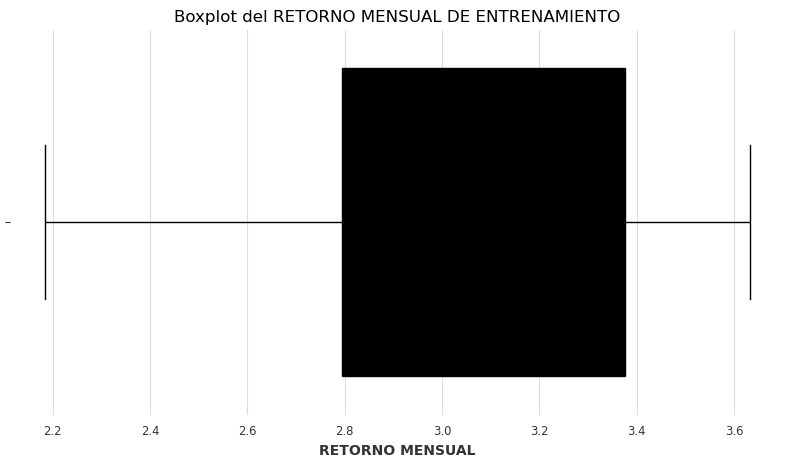

In [121]:
plt.figure(figsize=(10, 5))
sns.boxplot(x=df_train['PEN'])
plt.title('Boxplot del RETORNO MENSUAL DE ENTRENAMIENTO')
plt.xlabel('RETORNO MENSUAL')
plt.show()

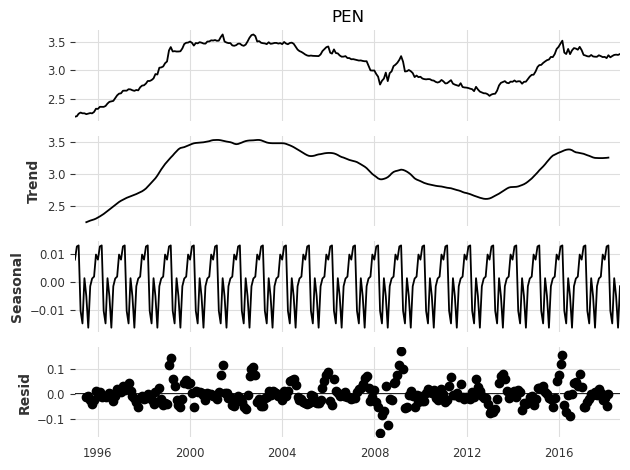

In [122]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Realizamos una descomposición aditiva
result = seasonal_decompose(df_train['PEN'], model='additive', period=12)
result.plot()
plt.show()

# Funciones auxiliares

In [123]:
# Decorador de progreso
def progress_decorator(func):
    def wrapper(*args, **kwargs):
        with tqdm(total=100) as pbar:
            kwargs['progress_bar'] = pbar
            result = func(*args, **kwargs)
        return result
    return wrapper

In [124]:
def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return {'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'R2': r2}

In [125]:
def save_hyperparameters(params, model_name):
    filename = f'best_hyperparameters_{model_name}.json'
    with open(filename, 'w') as f:
        json.dump(params, f)
    print(f"Hiperparámetros guardados en {filename}")
    

In [126]:
def load_hyperparameters(model_name):
    filename = f'best_hyperparameters_{model_name}.json'
    try:
        with open(filename, 'r') as f:
            return json.load(f)
    except FileNotFoundError:
        return None

In [127]:
def save_model(model, model_name):
    filename = f'{model_name}_model.pkl'
    with open(filename, 'wb') as f:
        pickle.dump(model, f)
    print(f"Modelo guardado en {filename}")



In [128]:
def load_model(model_name):
    filename = f'{model_name}_model.pkl'
    try:
        with open(filename, 'rb') as f:
            return pickle.load(f)
    except FileNotFoundError:
        return None

In [129]:
# 3. Optimización de hiperparámetros (con carga/guardado)
# (Se implementará para cada modelo)

# 4. Entrenamiento de modelos
# (Se implementará para cada modelo)

In [130]:
# 5. Rolling forecast

def step_by_step_forecast(model, train_data, test_data, retrain=False, progress_bar=None, model_name='model'):
    forecast_filename = f'{model_name}_forecast_{"retrain" if retrain else "no_retrain"}.pkl'
    
    # Intentar cargar la serie forecast si existe
    if os.path.exists(forecast_filename):
        print(f"Cargando forecast guardado de {forecast_filename}")
        with open(forecast_filename, 'rb') as f:
            return pickle.load(f)
    
    predictions = []
    current_series = train_data.copy()
    actual_values = test_data.values()
    test_index = test_data.time_index
    
    freq = pd.infer_freq(test_index)
    if freq is None:
        freq = 'M'
    
    for i in range(len(test_data)):
        pred = model.predict(n=1, series=current_series)
        predictions.append(pred)
        
        new_point = TimeSeries.from_dataframe(
            pd.DataFrame({test_data.components[0]: [actual_values[i]]}, index=[test_index[i]]),
            freq=freq,
            fill_missing_dates=True
        )
        
        current_series = current_series.append(new_point)
        
        if retrain:
            model.fit(current_series, verbose=False)
        
        if progress_bar:
            progress_bar.update(100 // len(test_data))
    
    if predictions:
        forecast = predictions[0]
        for pred in predictions[1:]:
            forecast = forecast.concatenate(pred)
    else:
        # En lugar de devolver un TimeSeries vacío, lanzar una advertencia o excepción
        raise ValueError("No se generaron predicciones. Verifica el modelo o los datos de entrada.")
    
    # Guardar la serie forecast
    print(f"Guardando forecast en {forecast_filename}")
    with open(forecast_filename, 'wb') as f:
        pickle.dump(forecast, f)
    
    return forecast

In [131]:
# 6. Evaluación y comparación de modelos
# (Se implementará después de entrenar todos los modelos)

In [132]:
# 7. Estrategia de trading y retornos acumulados
def implement_trading_strategy(real_returns, predicted_returns):
    if isinstance(real_returns, np.ndarray):
        real_returns_pd = pd.Series(real_returns)
    elif isinstance(real_returns, pd.Series):
        real_returns_pd = real_returns
    else:
        raise ValueError("real_returns must be either numpy array or pandas Series.")

    if isinstance(predicted_returns, np.ndarray):
        predicted_returns_pd = pd.Series(predicted_returns)
    elif isinstance(predicted_returns, pd.Series):
        predicted_returns_pd = predicted_returns
    else:
        raise ValueError("predicted_returns must be either numpy array or pandas Series.")

    # Create the position and calculate strategy returns
    position = pd.Series(np.where(predicted_returns_pd > 0, 1, -1), index=predicted_returns_pd.index)
    strategy_returns = real_returns_pd * position
    
    return strategy_returns



In [133]:
# Transform the serie en returns
def return_series(series):
    if not isinstance(series, pd.Series):
        raise TypeError("La serie debe ser un objeto de tipo pandas.Series para calcular los retornos.")
    return series.pct_change().dropna()

In [134]:
def calculate_cumulative_return(returns):
    return (1 + returns).cumprod() - 1

In [135]:
def calculate_performance_metrics(pred_returns, benchmark_returns=None):
    # Asegurar que los inputs sean pandas.Series
    if not isinstance(pred_returns, pd.Series):
        pred_returns = pd.Series(pred_returns)
    
    # Crear un benchmark de ceros si no se proporciona uno
    if benchmark_returns is None:
        benchmark_returns = pd.Series([0] * len(pred_returns), index=pred_returns.index)
    elif not isinstance(benchmark_returns, pd.Series):
        benchmark_returns = pd.Series(benchmark_returns)
    
    # Retornos totales y anualizados
    total_return = (1 + pred_returns).prod() - 1
    annualized_return = (1 + total_return) ** (12 / len(pred_returns)) - 1

    # Sharpe Ratio (sin tasa libre de riesgo)
    sharpe_ratio = np.sqrt(12) * pred_returns.mean() / pred_returns.std()

    # Exceso de retornos para Information Ratio
    excess_returns = pred_returns - benchmark_returns
    tracking_error = excess_returns.std()
    information_ratio = excess_returns.mean() / tracking_error

    # Máximo Drawdown
    cumulative_returns = (1 + pred_returns).cumprod()
    peak = cumulative_returns.cummax()
    max_drawdown = ((cumulative_returns / peak) - 1).min()

    return {
        "Total Return": total_return,
        "Annualized Return": annualized_return,
        "Sharpe Ratio": sharpe_ratio,
        "Information Ratio": information_ratio,
        "Max Drawdown": max_drawdown
    }


In [136]:
def calculate_hit_ratio(y_pred, y_true=None):
    """
    Calcula el Hit Ratio entre los valores reales y predichos.
    
    :param y_true: Array o Series con los valores reales, usa y_pred como y_true si no se proporciona
    :param y_pred: Array o Series con los valores predichos
    :return: Tupla con (hit_ratio, hit_ratio_string)
    
    Si y_true no se proporciona, se calculará el hit ratio de y_pred contra sí mismo.
    """
    if y_true is None:
        y_true = y_pred
    if isinstance(y_true, pd.Series):
        y_true = y_true.to_numpy()
    if isinstance(y_pred, pd.Series):
        y_pred = y_pred.to_numpy()

    if len(y_pred) != len(y_true):
        raise ValueError("y_pred and y_true must have the same length.")

    same_sign_count = np.sum(np.sign(y_pred) == np.sign(y_true))
    hit_ratio = same_sign_count / len(y_true) * 100

    hit_ratio_string = f'Hit Ratio = {hit_ratio:.2f}%'
    
    return hit_ratio, hit_ratio_string

In [137]:
# Función para calcular todas las métricas incluyendo Hit Ratio
def calculate_all_metrics(pred_returns,real_returns=None):
    performance_metrics = calculate_performance_metrics(pred_returns,real_returns)
    hit_ratio, hit_ratio_string = calculate_hit_ratio(pred_returns,real_returns)
    
    all_metrics = {
        **performance_metrics,
        "Hit Ratio": hit_ratio,

    }
    
    return all_metrics

In [138]:
def ensure_numpy_array(data):
    if isinstance(data, TimeSeries):
        return data.values().flatten()
    elif isinstance(data, np.ndarray):
        return data.flatten()
    elif isinstance(data, pd.Series):
        return data.values
    else:
        return np.array(data).flatten()

In [139]:
def evaluate_model_performance(y_true, y_pred, model_name, retrain=False):
    # Handle Darts TimeSeries objects
    if isinstance(y_true, TimeSeries):
        y_true = y_true.values()  # Convert to NumPy array
    if isinstance(y_pred, TimeSeries):
        y_pred = y_pred.values()  # Convert to NumPy array

    # Ensure y_true and y_pred are numpy arrays or pandas Series
    if not isinstance(y_true, (np.ndarray, pd.Series)):
        raise TypeError(f"y_true debe ser un numpy.ndarray, pandas.Series o Darts TimeSeries, pero se recibió {type(y_true)}")
    if not isinstance(y_pred, (np.ndarray, pd.Series)):
        raise TypeError(f"y_pred debe ser un numpy.ndarray, pandas.Series o Darts TimeSeries, pero se recibió {type(y_pred)}")

    # Convert to numpy array if it's a pandas Series
    y_true_np = y_true.values if isinstance(y_true, pd.Series) else y_true
    y_pred_np = y_pred.values if isinstance(y_pred, pd.Series) else y_pred

    # Error metrics calculation
    mse = mean_squared_error(y_true_np, y_pred_np)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true_np, y_pred_np)
    r2 = r2_score(y_true_np, y_pred_np)

    error_metrics = {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2
    }

    # Convert to pandas Series for return calculations
    y_true_series = pd.Series(y_true.flatten()) if isinstance(y_true, np.ndarray) else y_true
    y_pred_series = pd.Series(y_pred.flatten()) if isinstance(y_pred, np.ndarray) else y_pred

    # Ensure they are Series before calculating returns
    try:
        y_true_returns = return_series(y_true_series)
        y_pred_returns = return_series(y_pred_series)
    except TypeError as e:
        print(f"Error: {e}")
        return None, None

    # Implement trading strategy
    strategy_returns = implement_trading_strategy(y_true_returns, y_pred_returns)

    # Calculate performance metrics
    performance_metrics = calculate_performance_metrics(strategy_returns, y_true_returns)

    # Calculate Hit Ratio
    hit_ratio, hit_ratio_string = calculate_hit_ratio(y_pred_returns, y_true_returns)

    # Combine all metrics
    all_metrics = {
        "Model": model_name,
        "Retrain": retrain,
        **error_metrics,
        **performance_metrics,
        "Hit Ratio": hit_ratio
    }

    return all_metrics, strategy_returns

# NBeats
Esta clase implementa el modelo NBeats, que es un modelo de redes neuronales que se enfoca en la predicción de series de tiempo. El modelo se basa en la arquitectura de un bloque de NBeats, que consiste en una red feedforward con dos capas ocultas y una capa de salida. La red feedforward se aplica a una serie de tiempo y se entrena para predecir los valores futuros de la serie de tiempo. El modelo NBeats se puede utilizar para predecir series de tiempo univariadas y multivariadas.

In [140]:
# NBEATS Implementation

# Preprocesamiento de datos
series = TimeSeries.from_dataframe(df[['PEN']])
train_size = int(len(series) * 0.8)
train, test = series[:train_size], series[train_size:]

scaler = Scaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)


In [141]:
# Optimización de hiperparámetros
def optimize_nbeats(train_data):
    
    def objective(trial):
        # Definir los hiperparámetros que vamos a optimizar
        params = {
            'input_chunk_length': trial.suggest_int('input_chunk_length', 6, 24),
            'output_chunk_length': trial.suggest_int('output_chunk_length', 1, 5),  # Predicción paso a paso
            'num_stacks': trial.suggest_int('num_stacks', 5, 15),
            'num_blocks': trial.suggest_int('num_blocks', 1, 3),
            'num_layers': trial.suggest_int('num_layers', 2, 6),
            'layer_widths': trial.suggest_categorical('layer_widths', [64, 128, 256]),
            'dropout': trial.suggest_float('dropout', 0.0, 0.3),
            'n_epochs': 20,
            'random_state': 42
        }

        # Crear el modelo NBEATS con los parámetros sugeridos
        model = NBEATSModel(**params)

        # Realizar predicciones históricas para la validación cruzada
        backtest = model.historical_forecasts(
            series=train_data,
            start=train_data.time_index[int(len(train_data) * 0.7)],  # Comenzar el backtesting en el 80% de la serie
            forecast_horizon=3,  # Extender de 1 a 3 para agilizar
            stride=1,  # Desplazamiento de un paso subirlo a 3 para agilizar
            retrain=True,  # Reentrenar el modelo en cada paso
            verbose=False,
            show_warnings = False
        )

        # Evaluar el error usando MAE
        error = mae(train_data.slice_intersect(backtest), backtest)
        
        return error

    # Configurar el estudio de optimización con Optuna
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=50)
    
    # Obtener los mejores parámetros
    best_params = study.best_params
    best_params['output_chunk_length']= 1
    best_params['n_epochs'] = 100  # Ajuste final de épocas
    best_params['random_state'] = 42
    
    return best_params

In [142]:
# Entrenamiento del modelo
def train_nbeats(train_data):
    loaded_params = load_hyperparameters('nbeats')
    if loaded_params is None:
        print("Optimizando hiperparámetros para NBEATS...")
        best_params = optimize_nbeats(train_data)
        save_hyperparameters(best_params, 'nbeats')
    else:
        print("Cargando hiperparámetros guardados para NBEATS...")
        best_params = loaded_params
    
    model = NBEATSModel(**best_params)
    model.fit(train_data, verbose=False)
    save_model(model, 'nbeats')
    return model

In [143]:
# Entrenar modelo NBEATS
nbeats_model = train_nbeats(train_scaled,)



Cargando hiperparámetros guardados para NBEATS...
Modelo guardado en nbeats_model.pkl


In [144]:
# Uso de step_by_step_forecast sin reentrenamiento (como lo hicimos antes)
nbeats_forecast_no_retrain = step_by_step_forecast(nbeats_model, train_scaled, test_scaled, retrain=False, model_name='nbeats')

Cargando forecast guardado de nbeats_forecast_no_retrain.pkl


In [145]:
# Uso de step_by_step_forecast con reentrenamiento
nbeats_forecast_with_retrain = step_by_step_forecast(nbeats_model, train_scaled, test_scaled, retrain=True, model_name='nbeats')

Cargando forecast guardado de nbeats_forecast_retrain.pkl


In [146]:
# Desescalar las predicciones
nbeats_forecast_no_retrain_unscaled = scaler.inverse_transform(nbeats_forecast_no_retrain)
nbeats_forecast_with_retrain_unscaled = scaler.inverse_transform(nbeats_forecast_with_retrain)

In [147]:
# Evaluar ambos modelos
y_true = test.values().flatten()
y_pred_no_retrain = nbeats_forecast_no_retrain_unscaled.values().flatten()
y_pred_with_retrain = nbeats_forecast_with_retrain_unscaled.values().flatten()

nbeats_evaluation_no_retrain = evaluate_model(y_true, y_pred_no_retrain)
nbeats_evaluation_with_retrain = evaluate_model(y_true, y_pred_with_retrain)

print("Evaluación del modelo NBEATS sin reentrenamiento:")
for metric, value in nbeats_evaluation_no_retrain.items():
    print(f"{metric}: {value:.6f}")

print("\nEvaluación del modelo NBEATS con reentrenamiento:")
for metric, value in nbeats_evaluation_with_retrain.items():
    print(f"{metric}: {value:.6f}")

Evaluación del modelo NBEATS sin reentrenamiento:
MSE: 0.017534
RMSE: 0.132415
MAE: 0.107323
R2: 0.666389

Evaluación del modelo NBEATS con reentrenamiento:
MSE: 0.007792
RMSE: 0.088273
MAE: 0.070538
R2: 0.851741


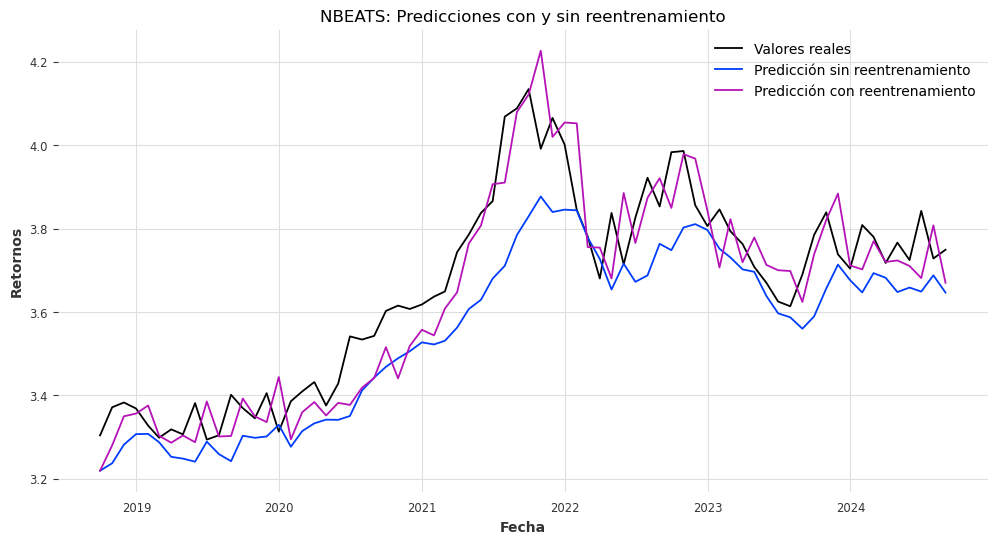

In [148]:
# Visualizar resultados
plt.figure(figsize=(12, 6))
plt.plot(test.time_index, y_true, label='Valores reales')
plt.plot(test.time_index, y_pred_no_retrain, label='Predicción sin reentrenamiento')
plt.plot(test.time_index, y_pred_with_retrain, label='Predicción con reentrenamiento')
plt.legend()
plt.title('NBEATS: Predicciones con y sin reentrenamiento')
plt.xlabel('Fecha')
plt.ylabel('Retornos')
plt.show()

In [149]:
# Implementar estrategia de trading para ambos casos
real_returns = return_series(test.pd_series())
pred_returns_no_retrain = return_series(nbeats_forecast_no_retrain_unscaled.pd_series())
pred_returns_with_retrain = return_series(nbeats_forecast_with_retrain_unscaled.pd_series())

In [150]:
strategy_returns_no_retrain = implement_trading_strategy(real_returns, pred_returns_no_retrain)
strategy_returns_with_retrain = implement_trading_strategy(real_returns, pred_returns_with_retrain)

In [151]:
# Calcular retornos acumulados
cumulative_real = calculate_cumulative_return(real_returns)
cumulative_strategy_no_retrain = calculate_cumulative_return(strategy_returns_no_retrain)
cumulative_strategy_with_retrain = calculate_cumulative_return(strategy_returns_with_retrain)

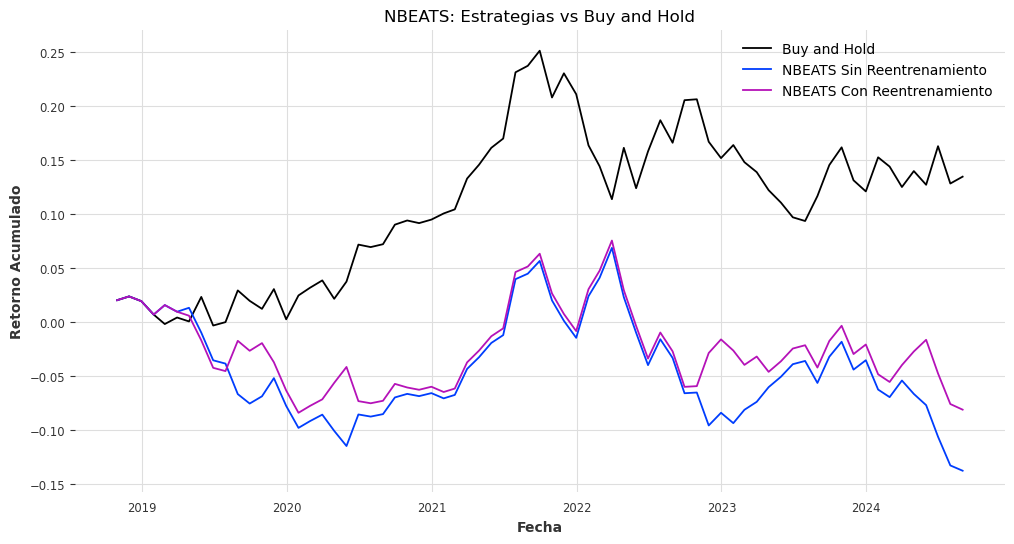

In [152]:
# Visualizar resultados de la estrategia
plt.figure(figsize=(12, 6))
plt.plot(cumulative_real.index, cumulative_real, label='Buy and Hold')
plt.plot(cumulative_strategy_no_retrain.index, cumulative_strategy_no_retrain, label='NBEATS Sin Reentrenamiento')
plt.plot(cumulative_strategy_with_retrain.index, cumulative_strategy_with_retrain, label='NBEATS Con Reentrenamiento')
plt.legend()
plt.title('NBEATS: Estrategias vs Buy and Hold')
plt.xlabel('Fecha')
plt.ylabel('Retorno Acumulado')
plt.show()

In [153]:
hit_ratio, hit_ratio_string = calculate_hit_ratio(pred_returns_with_retrain, real_returns)

In [154]:
hit_ratio_string

'Hit Ratio = 52.11%'

In [155]:
# Calcular métricas de rendimiento para ambas estrategias
metrics_buy_hold = calculate_all_metrics(real_returns)
metrics_strategy_no_retrain = calculate_all_metrics(strategy_returns_no_retrain,real_returns)
metrics_strategy_with_retrain = calculate_all_metrics(strategy_returns_with_retrain,real_returns)

print("\nMétricas de rendimiento:")
print("\nBuy and Hold:")
for k, v in metrics_buy_hold.items():
    print(f"{k}: {v:.4f}")
print("\nEstrategia NBEATS sin reentrenamiento:")
for k, v in metrics_strategy_no_retrain.items():
    print(f"{k}: {v:.4f}")
print("\nEstrategia NBEATS con reentrenamiento:")
for k, v in metrics_strategy_with_retrain.items():
    print(f"{k}: {v:.4f}")


Métricas de rendimiento:

Buy and Hold:
Total Return: 0.1348
Annualized Return: 0.0216
Sharpe Ratio: 0.3437
Information Ratio: 0.0992
Max Drawdown: -0.1260
Hit Ratio: 100.0000

Estrategia NBEATS sin reentrenamiento:
Total Return: -0.1374
Annualized Return: -0.0247
Sharpe Ratio: -0.3272
Information Ratio: -0.1439
Max Drawdown: -0.1930
Hit Ratio: 54.9296

Estrategia NBEATS con reentrenamiento:
Total Return: -0.0809
Annualized Return: -0.0142
Sharpe Ratio: -0.1714
Information Ratio: -0.1053
Max Drawdown: -0.1455
Hit Ratio: 54.9296


In [156]:
nbeats_metrics_no_retrain, nbeats_returns_no_retrain = evaluate_model_performance(
    y_true, y_pred_no_retrain, "NBEATS", retrain=False)
nbeats_metrics_with_retrain, nbeats_returns_with_retrain = evaluate_model_performance(
    y_true, y_pred_with_retrain, "NBEATS", retrain=True)

# NHITS (NBeats Hierarchical Iterative Time Series)
Esta clase implementa el modelo NHITS, que es un modelo de redes neuronales que se enfoca en la predicción de series de tiempo. El modelo se basa en la arquitectura de un bloque de NBeats, que consiste en una red feedforward con dos capas ocultas y una capa de salida. La red feedforward se aplica a una serie de tiempo y se entrena para predecir los valores futuros de la serie de tiempo. El modelo NHITS se puede utilizar para predecir series de tiempo univariadas y multivariadas.

In [157]:
# Preprocesamiento de datos
series = TimeSeries.from_dataframe(df[['PEN']])
train_size = int(len(series) * 0.8)
train, test = series[:train_size], series[train_size:]

scaler = Scaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

In [ ]:
def optimize_nhits(train_data):
    def objective(trial):
        # Definir los hiperparámetros que vamos a optimizar, dejando los demás como valores por defecto
        params = {
            'input_chunk_length': trial.suggest_int('input_chunk_length', 6, 24),
            'output_chunk_length': 1,  # Predicción paso a paso
            'num_stacks': trial.suggest_int('num_stacks', 2, 8),
            'num_blocks': trial.suggest_int('num_blocks', 1, 3),
            'num_layers': trial.suggest_int('num_layers', 2, 4),
            'layer_widths': trial.suggest_categorical('layer_widths', [64, 128, 256]),
            'dropout': trial.suggest_float('dropout', 0.0, 0.3),
            'n_epochs': 20,
            'random_state': 42
        }

        # Crear el modelo N-HiTS con los parámetros sugeridos
        model = NHiTSModel(**params)

        # Realizar predicciones históricas para la validación cruzada
        backtest = model.historical_forecasts(
            series=train_data,
            start=train_data.time_index[int(len(train_data) * 0.8)],  # Comenzar el backtesting en el 80% de la serie
            forecast_horizon=3,  # Predicción de un paso a la vez
            stride=3,  # Desplazamiento de un paso
            retrain=True,  # Reentrenar el modelo en cada paso
            verbose=False,
            show_warnings=False
        )

        # Evaluar el error usando MAE
        error = mae(train_data.slice_intersect(backtest), backtest)
        
        return error

    # Configurar el estudio de optimización con Optuna
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=50)
    
    # Obtener los mejores parámetros
    best_params = study.best_params
    best_params['output_chunk_length']= 1
    best_params['n_epochs'] = 100  # Ajuste final de épocas
    best_params['random_state'] = 42
    
    return best_params







In [159]:
# Entrenamiento del modelo
def train_nhits(train_data):
    loaded_params = load_hyperparameters('nhits')
    if loaded_params is None:
        print("Optimizando hiperparámetros para NHITS...")
        best_params = optimize_nhits(train_data)
        save_hyperparameters(best_params, 'nhits')
    else:
        print("Cargando hiperparámetros guardados para NHITS...")
        best_params = loaded_params
    
    model = NHiTSModel(**best_params)
    model.fit(train_data, verbose=False)
    save_model(model, 'nhits')
    return model

In [160]:
# Entrenar modelo NHITS
nhits_model = train_nhits(train_scaled)

Cargando hiperparámetros guardados para NHITS...
Modelo guardado en nhits_model.pkl


In [161]:
# Realizar rolling forecast
nhits_forecast_no_retrain = step_by_step_forecast(nhits_model, train_scaled, test_scaled, retrain=False, model_name='nhits')


Cargando forecast guardado de nhits_forecast_no_retrain.pkl


In [162]:
nhits_forecast_with_retrain = step_by_step_forecast(nhits_model, train_scaled, test_scaled, retrain=True, model_name='nhits')

Cargando forecast guardado de nhits_forecast_retrain.pkl


In [163]:
# Desescalar las predicciones
nhits_forecast_no_retrain_unscaled = scaler.inverse_transform(nhits_forecast_no_retrain)
nhits_forecast_with_retrain_unscaled = scaler.inverse_transform(nhits_forecast_with_retrain)

In [164]:
# Evaluar ambos modelos
y_true = test.values().flatten()
y_pred_no_retrain = nhits_forecast_no_retrain_unscaled.values().flatten()
y_pred_with_retrain = nhits_forecast_with_retrain_unscaled.values().flatten()

nhits_evaluation_no_retrain = evaluate_model(y_true, y_pred_no_retrain)
nhits_evaluation_with_retrain = evaluate_model(y_true, y_pred_with_retrain)

In [165]:
print("Evaluación del modelo NHITS sin reentrenamiento:")
for metric, value in nhits_evaluation_no_retrain.items():
    print(f"{metric}: {value:.6f}")

print("\nEvaluación del modelo NHITS con reentrenamiento:")
for metric, value in nhits_evaluation_with_retrain.items():
    print(f"{metric}: {value:.6f}")

Evaluación del modelo NHITS sin reentrenamiento:
MSE: 0.012973
RMSE: 0.113899
MAE: 0.085447
R2: 0.753167

Evaluación del modelo NHITS con reentrenamiento:
MSE: 0.007459
RMSE: 0.086364
MAE: 0.070187
R2: 0.858083


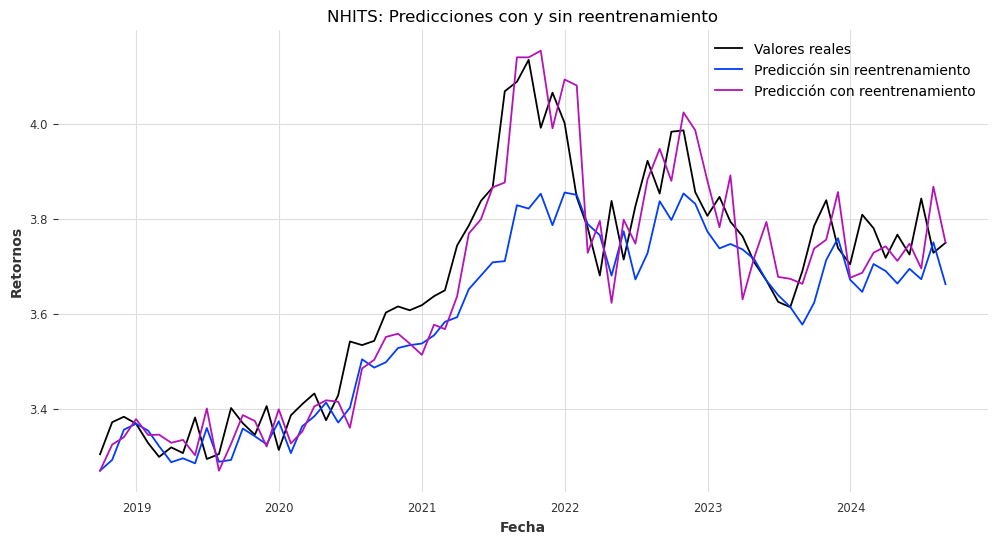

In [166]:
# Visualizar resultados
plt.figure(figsize=(12, 6))
plt.plot(test.time_index, y_true, label='Valores reales')
plt.plot(test.time_index, y_pred_no_retrain, label='Predicción sin reentrenamiento')
plt.plot(test.time_index, y_pred_with_retrain, label='Predicción con reentrenamiento')
plt.legend()
plt.title('NHITS: Predicciones con y sin reentrenamiento')
plt.xlabel('Fecha')
plt.ylabel('Retornos')
plt.show()

In [167]:
# Implementar estrategia de trading para ambos casos
real_returns = return_series(test.pd_series())
pred_returns_no_retrain = return_series(nhits_forecast_no_retrain_unscaled.pd_series())
pred_returns_with_retrain = return_series(nhits_forecast_with_retrain_unscaled.pd_series())

strategy_returns_no_retrain = implement_trading_strategy(real_returns, pred_returns_no_retrain)
strategy_returns_with_retrain = implement_trading_strategy(real_returns, pred_returns_with_retrain)

In [168]:
# Calcular retornos acumulados
cumulative_real = calculate_cumulative_return(real_returns)
cumulative_strategy_no_retrain = calculate_cumulative_return(strategy_returns_no_retrain)
cumulative_strategy_with_retrain = calculate_cumulative_return(strategy_returns_with_retrain)


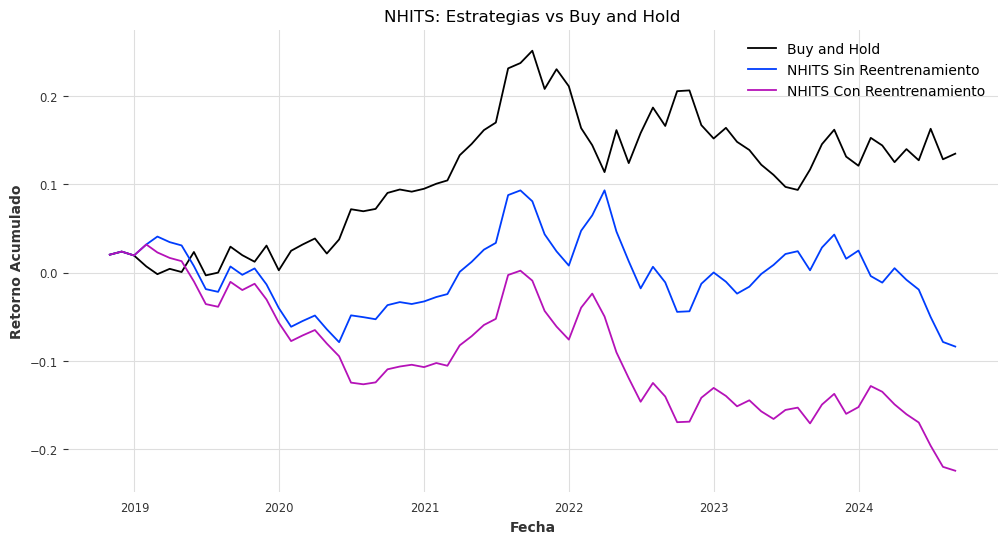

In [169]:
# Visualizar resultados de la estrategia
plt.figure(figsize=(12, 6))
plt.plot(cumulative_real.index, cumulative_real, label='Buy and Hold')
plt.plot(cumulative_strategy_no_retrain.index, cumulative_strategy_no_retrain, label='NHITS Sin Reentrenamiento')
plt.plot(cumulative_strategy_with_retrain.index, cumulative_strategy_with_retrain, label='NHITS Con Reentrenamiento')
plt.legend()
plt.title('NHITS: Estrategias vs Buy and Hold')
plt.xlabel('Fecha')
plt.ylabel('Retorno Acumulado')
plt.show()

In [170]:
# Calcular métricas de rendimiento para ambas estrategias
metrics_buy_hold = calculate_all_metrics(real_returns)
metrics_strategy_no_retrain = calculate_all_metrics(strategy_returns_no_retrain,real_returns)
metrics_strategy_with_retrain = calculate_all_metrics(strategy_returns_with_retrain,real_returns)

In [171]:
print("\nMétricas de rendimiento:")
print("\nBuy and Hold:")
for k, v in metrics_buy_hold.items():
    print(f"{k}: {v:.4f}")
print("\nEstrategia NHITS sin reentrenamiento:")
for k, v in metrics_strategy_no_retrain.items():
    print(f"{k}: {v:.4f}")
print("\nEstrategia NHITS con reentrenamiento:")
for k, v in metrics_strategy_with_retrain.items():
    print(f"{k}: {v:.4f}")


Métricas de rendimiento:

Buy and Hold:
Total Return: 0.1348
Annualized Return: 0.0216
Sharpe Ratio: 0.3437
Information Ratio: 0.0992
Max Drawdown: -0.1260
Hit Ratio: 100.0000

Estrategia NHITS sin reentrenamiento:
Total Return: -0.0836
Annualized Return: -0.0146
Sharpe Ratio: -0.1787
Information Ratio: -0.1092
Max Drawdown: -0.1618
Hit Ratio: 53.5211

Estrategia NHITS con reentrenamiento:
Total Return: -0.2242
Annualized Return: -0.0420
Sharpe Ratio: -0.5927
Information Ratio: -0.2055
Max Drawdown: -0.2482
Hit Ratio: 57.7465


In [172]:
nhits_metrics_no_retrain, nhits_returns_no_retrain = evaluate_model_performance(
    y_true, y_pred_no_retrain, "NHITS", retrain=False)

nhits_metrics_with_retrain, nhits_returns_with_retrain = evaluate_model_performance(
    y_true, y_pred_with_retrain, "NHITS", retrain=True)

# AUTOARIMA

In [173]:
# Preprocesamiento de datos
series = TimeSeries.from_dataframe(df[['PEN']])
train_size = int(len(series) * 0.8)
train, test = series[:train_size], series[train_size:]

scaler = Scaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

In [174]:
def autoarima_step_by_step_forecast(model, train_data, test_data, retrain=False, progress_bar=None):
    forecast_filename = f'autoarima_forecast_{"retrain" if retrain else "no_retrain"}.pkl'
    
    # Intentar cargar la serie forecast si existe
    if os.path.exists(forecast_filename):
        print(f"Cargando forecast guardado de {forecast_filename}")
        with open(forecast_filename, 'rb') as f:
            return pickle.load(f)
    
    predictions = []
    current_series = train_data.copy()
    actual_values = test_data.values()
    test_index = test_data.time_index
    
    freq = pd.infer_freq(test_index)
    if freq is None:
        freq = 'M'
    
    for i in range(len(test_data)):
        pred = model.predict(n=1)
        predictions.append(pred)
        
        new_point = TimeSeries.from_dataframe(
            pd.DataFrame({test_data.components[0]: [actual_values[i]]}, index=[test_index[i]]),
            freq=freq,
            fill_missing_dates=True
        )
        
        current_series = current_series.append(new_point)
        
        if retrain:
            model.fit(current_series)
        
        if progress_bar:
            progress_bar.update(100 // len(test_data))
    
    if predictions:
        # Concatenar todas las predicciones
        forecast_values = np.concatenate([pred.values() for pred in predictions])
        
        # Crear un nuevo TimeSeries con los valores pronosticados y el índice de tiempo correcto
        forecast = TimeSeries.from_times_and_values(
            times=test_data.time_index,
            values=forecast_values,
            freq=freq
        )
    else:
        # En lugar de devolver un TimeSeries vacío, lanzar una advertencia o excepción
        raise ValueError("No se generaron predicciones. Verifica el modelo o los datos de entrada.")
    
    # Guardar la serie forecast
    print(f"Guardando forecast en {forecast_filename}")
    with open(forecast_filename, 'wb') as f:
        pickle.dump(forecast, f)
    
    return forecast

In [175]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity_and_differencing(series, alpha=0.05, max_diff=5):
    """
    Test series for stationarity using the Augmented Dickey-Fuller test and determine the number of differencing needed.
    
    Parameters:
        series (pd.Series or np.ndarray): The time series data.
        alpha (float): The significance level to determine stationarity.
        max_diff (int): Maximum number of differencing steps to test.
    
    Returns:
        int: The number of differencing steps suggested.
        pd.Series: The differenced series that passed the ADF test.
    """
    # Ensure series is a pandas Series
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    
    # Apply ADF test iteratively
    for d in range(max_diff + 1):
        if d > 0:
            # Difference the series
            diff_series = series.diff(periods=d).dropna()
        else:
            diff_series = series
        
        adf_result = adfuller(diff_series)
        p_value = adf_result[1]  # p-value
        
        print(f"Differencing level {d}: ADF Statistic: {adf_result[0]}, p-value: {p_value}")
        
        # Check if the series is stationary
        if p_value < alpha:
            print(f"Series is stationary after {d} differencing step(s).")
            return d, diff_series
    
    print("Series is not stationary even after maximum allowed differencing.")
    return d, diff_series

diferencias, diff_series = test_stationarity_and_differencing(df['PEN'], max_diff=5)

Differencing level 0: ADF Statistic: -2.00501168406024, p-value: 0.2843799830877552
Differencing level 1: ADF Statistic: -18.935663197488175, p-value: 0.0
Series is stationary after 1 differencing step(s).


In [176]:
def train_autoarima(train_data,diferencias):
    # Configuración del modelo AutoARIMA para una serie mensual
    model = AutoARIMA(
        d=diferencias,
        start_p=1,
        start_q=1,
        max_p=5,
        max_q=5,
        seasonal=True,
        seasonal_periods=12,  # Periodo estacional de 12 meses
        stepwise=True,
        suppress_warnings=True,
        error_action='ignore',
        random_state=42,
    )

    print("Entrenando modelo AutoARIMA para serie mensual...")
    model.fit(train_data)
    save_model(model, 'autoarima')
    return model

In [177]:
# Entrenar modelo AutoARIMA
autoarima_model = train_autoarima(train_scaled,diferencias)


Entrenando modelo AutoARIMA para serie mensual...
Modelo guardado en autoarima_model.pkl


In [178]:
modelo_subyacente = autoarima_model.model
# Imprime el resumen del modelo
print(modelo_subyacente.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  285
Model:               SARIMAX(1, 1, 1)   Log Likelihood                 592.853
Date:                Fri, 29 Nov 2024   AIC                          -1179.706
Time:                        01:02:03   BIC                          -1168.759
Sample:                             0   HQIC                         -1175.317
                                - 285                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9660      0.039     25.078      0.000       0.890       1.041
ma.L1         -0.9227      0.057    -16.048      0.000      -1.035      -0.810
sigma2         0.0009   4.45e-05     20.225      0.0

In [179]:
# Realizar rolling forecast
autoarima_forecast_no_retrain = autoarima_step_by_step_forecast(autoarima_model, train_scaled, test_scaled, retrain=False)


Cargando forecast guardado de autoarima_forecast_no_retrain.pkl


In [180]:
autoarima_forecast_with_retrain = autoarima_step_by_step_forecast(autoarima_model, train_scaled, test_scaled, retrain=True)

Cargando forecast guardado de autoarima_forecast_retrain.pkl


In [181]:
# Desescalar las predicciones
autoarima_forecast_no_retrain_unscaled = scaler.inverse_transform(autoarima_forecast_no_retrain)
autoarima_forecast_with_retrain_unscaled = scaler.inverse_transform(autoarima_forecast_with_retrain)

In [182]:
# Evaluar ambos modelos
y_true = test.values().flatten()
y_pred_no_retrain = autoarima_forecast_no_retrain_unscaled.values().flatten()
y_pred_with_retrain = autoarima_forecast_with_retrain_unscaled.values().flatten()

autoarima_evaluation_no_retrain = evaluate_model(y_true, y_pred_no_retrain)
autoarima_evaluation_with_retrain = evaluate_model(y_true, y_pred_with_retrain)

In [183]:
print("Evaluación del modelo AutoARIMA sin reentrenamiento:")
for metric, value in autoarima_evaluation_no_retrain.items():
    print(f"{metric}: {value:.6f}")

print("\nEvaluación del modelo AutoARIMA con reentrenamiento:")
for metric, value in autoarima_evaluation_with_retrain.items():
    print(f"{metric}: {value:.6f}")

Evaluación del modelo AutoARIMA sin reentrenamiento:
MSE: 0.189170
RMSE: 0.434936
MAE: 0.369611
R2: -2.599289

Evaluación del modelo AutoARIMA con reentrenamiento:
MSE: 0.005463
RMSE: 0.073915
MAE: 0.059149
R2: 0.896048


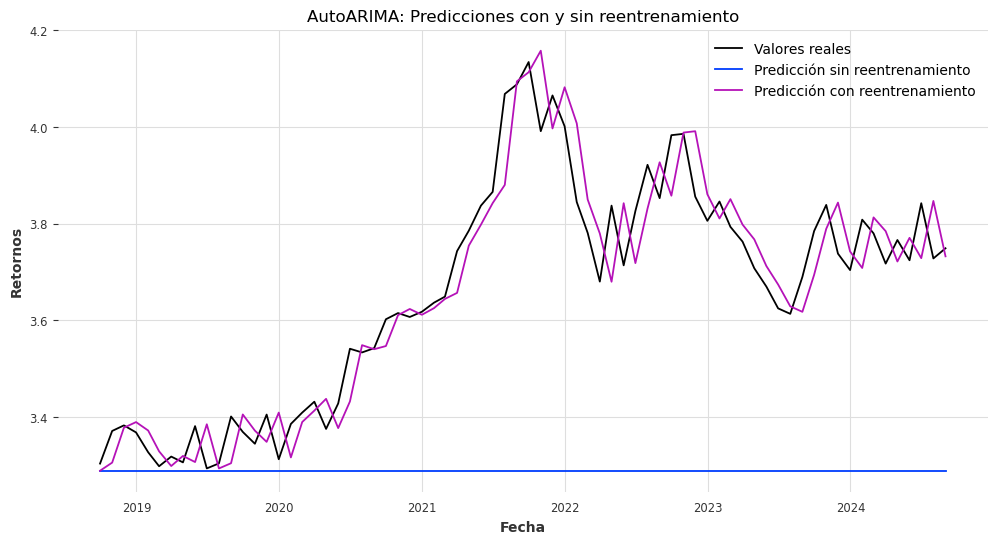

In [184]:
# Visualizar resultados
plt.figure(figsize=(12, 6))
plt.plot(test.time_index, y_true, label='Valores reales')
plt.plot(test.time_index, y_pred_no_retrain, label='Predicción sin reentrenamiento')
plt.plot(test.time_index, y_pred_with_retrain, label='Predicción con reentrenamiento')
plt.legend()
plt.title('AutoARIMA: Predicciones con y sin reentrenamiento')
plt.xlabel('Fecha')
plt.ylabel('Retornos')
plt.show()

In [185]:
# Implementar estrategia de trading para ambos casos
real_returns = return_series(test.pd_series())
pred_returns_no_retrain = return_series(autoarima_forecast_no_retrain_unscaled.pd_series())
pred_returns_with_retrain = return_series(autoarima_forecast_with_retrain_unscaled.pd_series())

In [186]:
strategy_returns_no_retrain = implement_trading_strategy(real_returns, pred_returns_no_retrain)
strategy_returns_with_retrain = implement_trading_strategy(real_returns, pred_returns_with_retrain)

In [187]:
# Calcular retornos acumulados
cumulative_real = calculate_cumulative_return(real_returns)
cumulative_strategy_no_retrain = calculate_cumulative_return(strategy_returns_no_retrain)
cumulative_strategy_with_retrain = calculate_cumulative_return(strategy_returns_with_retrain)

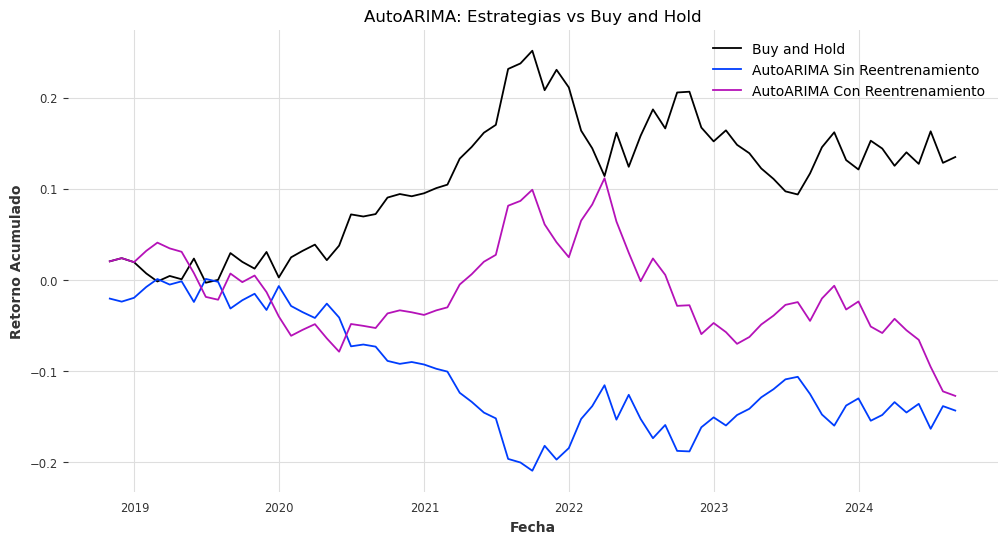

In [188]:
# Visualizar resultados de la estrategia
plt.figure(figsize=(12, 6))
plt.plot(cumulative_real.index, cumulative_real, label='Buy and Hold')
plt.plot(cumulative_strategy_no_retrain.index, cumulative_strategy_no_retrain, label='AutoARIMA Sin Reentrenamiento')
plt.plot(cumulative_strategy_with_retrain.index, cumulative_strategy_with_retrain, label='AutoARIMA Con Reentrenamiento')
plt.legend()
plt.title('AutoARIMA: Estrategias vs Buy and Hold')
plt.xlabel('Fecha')
plt.ylabel('Retorno Acumulado')
plt.show()

In [189]:
# Calcular métricas de rendimiento para ambas estrategias
metrics_buy_hold = calculate_all_metrics(real_returns)
metrics_strategy_no_retrain = calculate_all_metrics(strategy_returns_no_retrain,real_returns)
metrics_strategy_with_retrain = calculate_all_metrics(strategy_returns_with_retrain,real_returns)

print("\nMétricas de rendimiento:")
print("\nBuy and Hold:")
for k, v in metrics_buy_hold.items():
    print(f"{k}: {v:.4f}")
print("\nEstrategia AutoARIMA sin reentrenamiento:")
for k, v in metrics_strategy_no_retrain.items():
    print(f"{k}: {v:.4f}")
print("\nEstrategia AutoARIMA con reentrenamiento:")
for k, v in metrics_strategy_with_retrain.items():
    print(f"{k}: {v:.4f}")


Métricas de rendimiento:

Buy and Hold:
Total Return: 0.1348
Annualized Return: 0.0216
Sharpe Ratio: 0.3437
Information Ratio: 0.0992
Max Drawdown: -0.1260
Hit Ratio: 100.0000

Estrategia AutoARIMA sin reentrenamiento:
Total Return: -0.1432
Annualized Return: -0.0258
Sharpe Ratio: -0.3437
Information Ratio: -0.0992
Max Drawdown: -0.2101
Hit Ratio: 0.0000

Estrategia AutoARIMA con reentrenamiento:
Total Return: -0.1271
Annualized Return: -0.0227
Sharpe Ratio: -0.2979
Information Ratio: -0.1409
Max Drawdown: -0.2147
Hit Ratio: 54.9296


In [190]:
autoarima_metrics_no_retrain, autoarima_returns_no_retrain = evaluate_model_performance(
    y_true, y_pred_no_retrain, "AUTOARIMA", retrain=False)

autoarima_metrics_with_retrain, autoarima_returns_with_retrain = evaluate_model_performance(
    y_true, y_pred_with_retrain, "AUTOARIMA", retrain=True)

# TSMixer

In [191]:
# Preprocesamiento de datos
series = TimeSeries.from_dataframe(df[['PEN']])
train_size = int(len(series) * 0.8)
train, test = series[:train_size], series[train_size:]

scaler = Scaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

In [ ]:
def optimize_tsmixer(train_data):
    
    def objective(trial):
        # Definir los hiperparámetros a optimizar
        params = {
            'input_chunk_length': trial.suggest_int('input_chunk_length', 12, 72),
            'output_chunk_length': 1,  # Ajuste inicial, puedes experimentar con valores mayores
            'hidden_size': trial.suggest_categorical('hidden_size', [32, 64, 128, 256]),
            'ff_size': trial.suggest_categorical('ff_size', [64, 128, 256, 512]),
            'num_blocks': trial.suggest_int('num_blocks', 1, 4),
            'dropout': trial.suggest_float('dropout', 0.0, 0.5),
            'n_epochs': 20,  # Reducido para agilizar la optimización
            'random_state': 42
        }

        # Crear el modelo TSMixer con los parámetros sugeridos
        model = TSMixerModel(**params)

        # Realizar predicciones históricas para la validación cruzada
        backtest = model.historical_forecasts(
            series=train_data,
            start=train_data.time_index[int(len(train_data) * 0.8)],  # Comenzar el backtesting en el 80% de la serie
            forecast_horizon=3,  # Predicción de 3 pasos a la vez
            stride=3,  # Desplazamiento de 3 pasos
            retrain=True,  # Reentrenar el modelo en cada paso
            verbose=False,  # Suprimir mensajes para agilizar el proceso
            show_warnings=False  # Omitir warnings para hacer más fluido el proceso
        )

        # Evaluar el error usando MAE
        error = mae(train_data.slice_intersect(backtest), backtest)
        
        return error

    # Configurar el estudio de optimización con Optuna
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=50)  

    # Obtener los mejores parámetros
    best_params = study.best_params
    best_params['output_chunk_length']= 1
    best_params['n_epochs'] = 100  # Ajuste final de épocas para entrenamiento completo
    best_params['random_state'] = 42
    
    return best_params

In [193]:
def train_tsmixer(train_data):
    loaded_params = load_hyperparameters('tsmixer')
    if loaded_params is None:
        print("Optimizando hiperparámetros para TSMixer...")
        best_params = optimize_tsmixer(train_data)
        save_hyperparameters(best_params, 'tsmixer')
    else:
        print("Cargando hiperparámetros guardados para TSMixer...")
        best_params = loaded_params
    
    model = TSMixerModel(**best_params)
    model.fit(train_data, verbose=False)
    save_model(model, 'tsmixer')
    return model

In [194]:
# Entrenar modelo TSMixer
tsmixer_model = train_tsmixer(train_scaled)

Cargando hiperparámetros guardados para TSMixer...
Modelo guardado en tsmixer_model.pkl


In [195]:
# Realizar rolling forecast
tsmixer_forecast_no_retrain = step_by_step_forecast(tsmixer_model, train_scaled, test_scaled, retrain=False, model_name='tsmixer')

Cargando forecast guardado de tsmixer_forecast_no_retrain.pkl


In [196]:
tsmixer_forecast_with_retrain = step_by_step_forecast(tsmixer_model, train_scaled, test_scaled, retrain=True, model_name='tsmixer')

Cargando forecast guardado de tsmixer_forecast_retrain.pkl


In [197]:
# Desescalar las predicciones
tsmixer_forecast_no_retrain_unscaled = scaler.inverse_transform(tsmixer_forecast_no_retrain)
tsmixer_forecast_with_retrain_unscaled = scaler.inverse_transform(tsmixer_forecast_with_retrain)

In [198]:
# Evaluar ambos modelos
y_true = test.values().flatten()
y_pred_no_retrain = tsmixer_forecast_no_retrain_unscaled.values().flatten()
y_pred_with_retrain = tsmixer_forecast_with_retrain_unscaled.values().flatten()

tsmixer_evaluation_no_retrain = evaluate_model(y_true, y_pred_no_retrain)
tsmixer_evaluation_with_retrain = evaluate_model(y_true, y_pred_with_retrain)

print("Evaluación del modelo TSMixer sin reentrenamiento:")
for metric, value in tsmixer_evaluation_no_retrain.items():
    print(f"{metric}: {value:.6f}")

print("\nEvaluación del modelo TSMixer con reentrenamiento:")
for metric, value in tsmixer_evaluation_with_retrain.items():
    print(f"{metric}: {value:.6f}")

Evaluación del modelo TSMixer sin reentrenamiento:
MSE: 0.040648
RMSE: 0.201612
MAE: 0.165354
R2: 0.226608

Evaluación del modelo TSMixer con reentrenamiento:
MSE: 0.007794
RMSE: 0.088283
MAE: 0.071388
R2: 0.851707


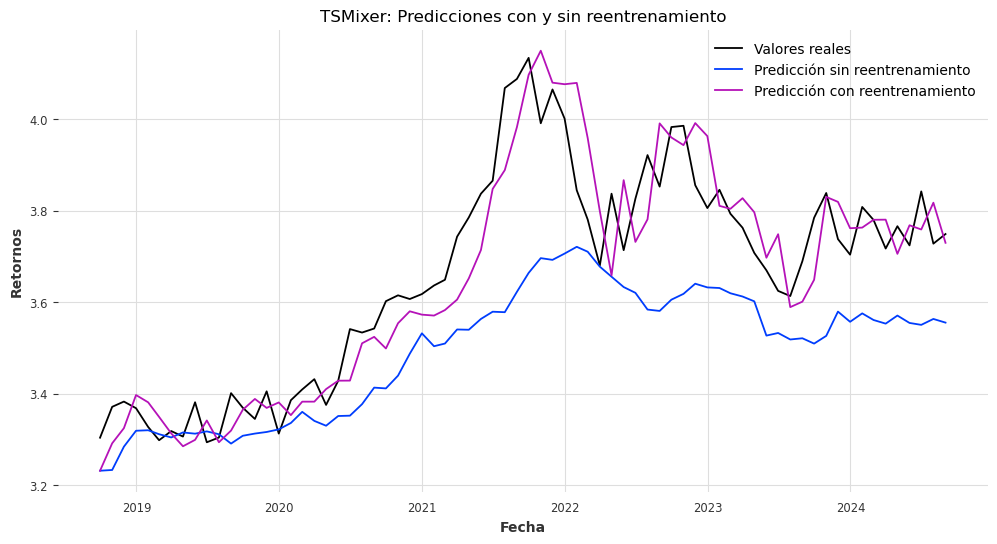

In [199]:
# Visualizar resultados
plt.figure(figsize=(12, 6))
plt.plot(test.time_index, y_true, label='Valores reales')
plt.plot(test.time_index, y_pred_no_retrain, label='Predicción sin reentrenamiento')
plt.plot(test.time_index, y_pred_with_retrain, label='Predicción con reentrenamiento')
plt.legend()
plt.title('TSMixer: Predicciones con y sin reentrenamiento')
plt.xlabel('Fecha')
plt.ylabel('Retornos')
plt.show()

In [200]:
# Implementar estrategia de trading para ambos casos
real_returns = return_series(test.pd_series())
pred_returns_no_retrain = return_series(tsmixer_forecast_no_retrain_unscaled.pd_series())
pred_returns_with_retrain = return_series(tsmixer_forecast_with_retrain_unscaled.pd_series())

strategy_returns_no_retrain = implement_trading_strategy(real_returns, pred_returns_no_retrain)
strategy_returns_with_retrain = implement_trading_strategy(real_returns, pred_returns_with_retrain)

In [201]:
# Calcular retornos acumulados
cumulative_real = calculate_cumulative_return(real_returns)
cumulative_strategy_no_retrain = calculate_cumulative_return(strategy_returns_no_retrain)
cumulative_strategy_with_retrain = calculate_cumulative_return(strategy_returns_with_retrain)

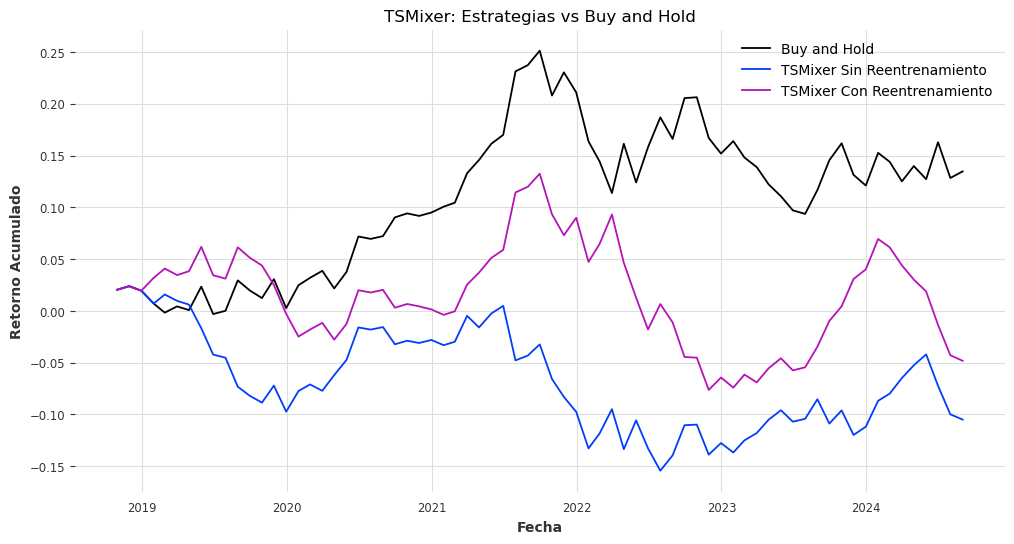

In [202]:
# Visualizar resultados de la estrategia
plt.figure(figsize=(12, 6))
plt.plot(cumulative_real.index, cumulative_real, label='Buy and Hold')
plt.plot(cumulative_strategy_no_retrain.index, cumulative_strategy_no_retrain, label='TSMixer Sin Reentrenamiento')
plt.plot(cumulative_strategy_with_retrain.index, cumulative_strategy_with_retrain, label='TSMixer Con Reentrenamiento')
plt.legend()
plt.title('TSMixer: Estrategias vs Buy and Hold')
plt.xlabel('Fecha')
plt.ylabel('Retorno Acumulado')
plt.show()

In [203]:
# Calcular métricas de rendimiento para ambas estrategias
metrics_buy_hold = calculate_all_metrics(real_returns)
metrics_strategy_no_retrain = calculate_all_metrics(strategy_returns_no_retrain,real_returns)
metrics_strategy_with_retrain = calculate_all_metrics(strategy_returns_with_retrain,real_returns)

print("\nMétricas de rendimiento:")
print("\nBuy and Hold:")
for k, v in metrics_buy_hold.items():
    print(f"{k}: {v:.4f}")
print("\nEstrategia TSMixer sin reentrenamiento:")
for k, v in metrics_strategy_no_retrain.items():
    print(f"{k}: {v:.4f}")
print("\nEstrategia TSMixer con reentrenamiento:")
for k, v in metrics_strategy_with_retrain.items():
    print(f"{k}: {v:.4f}")


Métricas de rendimiento:

Buy and Hold:
Total Return: 0.1348
Annualized Return: 0.0216
Sharpe Ratio: 0.3437
Information Ratio: 0.0992
Max Drawdown: -0.1260
Hit Ratio: 100.0000

Estrategia TSMixer sin reentrenamiento:
Total Return: -0.1050
Annualized Return: -0.0186
Sharpe Ratio: -0.2362
Information Ratio: -0.1184
Max Drawdown: -0.1741
Hit Ratio: 53.5211

Estrategia TSMixer con reentrenamiento:
Total Return: -0.0482
Annualized Return: -0.0083
Sharpe Ratio: -0.0861
Information Ratio: -0.1060
Max Drawdown: -0.1844
Hit Ratio: 59.1549


In [204]:
tsmixer_metrics_no_retrain, tsmixer_returns_no_retrain = evaluate_model_performance(
    y_true, y_pred_no_retrain, "TSMIXER", retrain=False)

tsmixer_metrics_with_retrain, tsmixer_returns_with_retrain = evaluate_model_performance(
    y_true, y_pred_with_retrain, "TSMIXER", retrain=True)

# CatBoost Regressor

In [205]:
# Preprocesamiento de datos
series = TimeSeries.from_dataframe(df[['PEN']])

train_size = int(len(series) * 0.8)
train, test = series[:train_size], series[train_size:]
pen = df[['PEN']][train_size:]

scaler = Scaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

In [206]:
def create_features(df, lags=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]):
    """Create time series features based on lags."""
    X = df[['PEN']].copy()
    
    # Crear características de lag
    for lag in lags:
        X[f'lag_{lag}'] = X['PEN'].shift(lag)
    
    # Añadir características temporales
    X['month'] = X.index.month
    X['year'] = X.index.year
    
    # Separar target (y) y features (X)
    y = X['PEN']
    X = X.drop(columns=['PEN'])
    
    return X, y

In [207]:
def optimize_catboost(X_train, y_train, X_val, y_val):
    def objective(trial):
        params = {
            'iterations': trial.suggest_int('iterations', 100, 1000),
            'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.1),
            'depth': trial.suggest_int('depth', 4, 10),
            'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-8, 10.0),
            'random_strength': trial.suggest_uniform('random_strength', 0.1, 10.0),
            'bagging_temperature': trial.suggest_uniform('bagging_temperature', 0.0, 1.0),
            'loss_function': 'RMSE',
            'random_state': 42
        }

        model = CatBoostRegressor(**params)
        model.fit(X_train, y_train, eval_set=(X_val, y_val), early_stopping_rounds=50, verbose=False)

        predictions = model.predict(X_val)
        mse = np.mean((y_val - predictions) ** 2)
        return mse

    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=50)

    best_params = study.best_params
    best_params['loss_function'] = 'RMSE'
    best_params['random_state'] = 42

    return best_params


In [208]:
def train_catboost(df):
    # Crear las características
    X, y = create_features(df)
    
    # Eliminar filas con NaN (causadas por los lags)
    X = X.dropna()
    y = y[X.index]
    
    # Separar datos en entrenamiento y prueba
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    
    # Separar datos de entrenamiento en train y validación
    val_size = int(len(X_train) * 0.2)
    X_train_opt, X_val = X_train[:-val_size], X_train[-val_size:]
    y_train_opt, y_val = y_train[:-val_size], y_train[-val_size:]
    
    # Escalar las características (excepto month y year)
    scaler = StandardScaler()
    numeric_cols = [col for col in X.columns if col.startswith('lag_')]
    
    # Escalar datos de entrenamiento
    X_train_scaled = X_train_opt.copy()
    X_val_scaled = X_val.copy()
    X_test_scaled = X_test.copy()
    
    X_train_scaled[numeric_cols] = scaler.fit_transform(X_train_opt[numeric_cols])
    X_val_scaled[numeric_cols] = scaler.transform(X_val[numeric_cols])
    X_test_scaled[numeric_cols] = scaler.transform(X_test[numeric_cols])
    
    # Optimizar hiperparámetros
    loaded_params = load_hyperparameters('catboost')
    if loaded_params is None:
        print("Optimizando hiperparámetros para CatBoost...")
        best_params = optimize_catboost(X_train_scaled, y_train_opt, X_val_scaled, y_val)
        save_hyperparameters(best_params, 'catboost')
    else:
        print("Cargando hiperparámetros guardados para CatBoost...")
        best_params = loaded_params

    # Entrenar el modelo final con todos los datos de entrenamiento
    X_train_full_scaled = X_train.copy()
    X_train_full_scaled[numeric_cols] = scaler.transform(X_train[numeric_cols])
    
    model = CatBoostRegressor(**best_params)
    model.fit(X_train_full_scaled, y_train, verbose=100)
    
    save_model(model, 'catboost')
    
    return model, X_test_scaled, y_test, scaler


In [209]:
# Entrenar modelo
catboost_model, X_test_scaled, y_test, scaler = train_catboost(df)

Cargando hiperparámetros guardados para CatBoost...
0:	learn: 0.3201631	total: 138ms	remaining: 1m 34s
100:	learn: 0.0625439	total: 199ms	remaining: 1.16s
200:	learn: 0.0415280	total: 256ms	remaining: 620ms
300:	learn: 0.0318927	total: 311ms	remaining: 400ms
400:	learn: 0.0249719	total: 380ms	remaining: 272ms
500:	learn: 0.0202036	total: 429ms	remaining: 160ms
600:	learn: 0.0164822	total: 479ms	remaining: 69.3ms
687:	learn: 0.0141416	total: 523ms	remaining: 0us
Modelo guardado en catboost_model.pkl


In [210]:
def catboost_step_by_step_forecast(model, train_data, test_data, scaler, retrain=False, progress_bar=None):
    """
    Realiza predicciones paso a paso usando el modelo CatBoost.
    """
    forecast_filename = f'catboost_forecast_{"retrain" if retrain else "no_retrain"}.pkl'
    
    if os.path.exists(forecast_filename):
        print(f"Cargando forecast guardado de {forecast_filename}")
        with open(forecast_filename, 'rb') as f:
            return pickle.load(f)
    
    predictions = []
    # Crear una copia explícita del DataFrame completo
    current_series = train_data.copy(deep=True)
    
    for i in range(len(test_data)):
        # Crear características para la predicción actual
        X_current, _ = create_features(current_series)
        X_current = X_current.dropna()
        
        if len(X_current) > 0:
            # Obtener las características más recientes
            latest_features = X_current.iloc[-1:].copy()
            
            # Escalar solo las características numéricas
            numeric_cols = [col for col in latest_features.columns if col.startswith('lag_')]
            if numeric_cols:
                # Usar loc para modificar el DataFrame
                latest_features.loc[:, numeric_cols] = scaler.transform(latest_features[numeric_cols])
            
            # Realizar predicción
            pred = model.predict(latest_features)
            predictions.append(pred[0])
        else:
            # Si no hay suficientes datos para crear características, usar el último valor
            predictions.append(current_series['PEN'].iloc[-1])
        
        # Actualizar la serie actual con el valor real
        new_data = pd.DataFrame({'PEN': [test_data.iloc[i]['PEN']]},
                              index=[test_data.index[i]])
        current_series = pd.concat([current_series, new_data])
        
        # Reentrenar si es necesario
        if retrain:
            X_train, y_train = create_features(current_series)
            X_train = X_train.dropna()
            y_train = y_train[X_train.index]
            
            # Escalar características numéricas
            numeric_cols = [col for col in X_train.columns if col.startswith('lag_')]
            if numeric_cols:
                # Usar loc para modificar el DataFrame
                X_train.loc[:, numeric_cols] = scaler.transform(X_train[numeric_cols])
            
            model.fit(X_train, y_train, verbose=False)
        
        if progress_bar:
            progress_bar.update(100 // len(test_data))
    
    predictions = np.array(predictions)
    
    print(f"Guardando forecast en {forecast_filename}")
    with open(forecast_filename, 'wb') as f:
        pickle.dump(predictions, f)
    
    return predictions

In [211]:
# Realizar predicciones
catboost_forecast_no_retrain = catboost_step_by_step_forecast(
    catboost_model, df[:train_size], df[train_size:], scaler, retrain=False)
catboost_forecast_with_retrain = catboost_step_by_step_forecast(
    catboost_model, df[:train_size], df[train_size:], scaler, retrain=True)

Cargando forecast guardado de catboost_forecast_no_retrain.pkl
Cargando forecast guardado de catboost_forecast_retrain.pkl


In [212]:
# Desescalar las predicciones
catboost_forecast_no_retrain_unscaled = catboost_forecast_no_retrain
catboost_forecast_with_retrain_unscaled = catboost_forecast_with_retrain

In [213]:
# Evaluar ambos modelos
y_true = test.values().flatten()
y_pred_no_retrain = catboost_forecast_no_retrain_unscaled.flatten()
y_pred_with_retrain = catboost_forecast_with_retrain_unscaled.flatten()

catboost_evaluation_no_retrain = evaluate_model(y_true, y_pred_no_retrain)
catboost_evaluation_with_retrain = evaluate_model(y_true, y_pred_with_retrain)

print("Evaluación del modelo CatBoost sin reentrenamiento:")
for metric, value in catboost_evaluation_no_retrain.items():
    print(f"{metric}: {value:.6f}")

print("\nEvaluación del modelo CatBoost con reentrenamiento:")
for metric, value in catboost_evaluation_with_retrain.items():
    print(f"{metric}: {value:.6f}")

Evaluación del modelo CatBoost sin reentrenamiento:
MSE: 0.004422
RMSE: 0.066499
MAE: 0.054363
R2: 0.915860

Evaluación del modelo CatBoost con reentrenamiento:
MSE: 0.005393
RMSE: 0.073436
MAE: 0.060135
R2: 0.897390


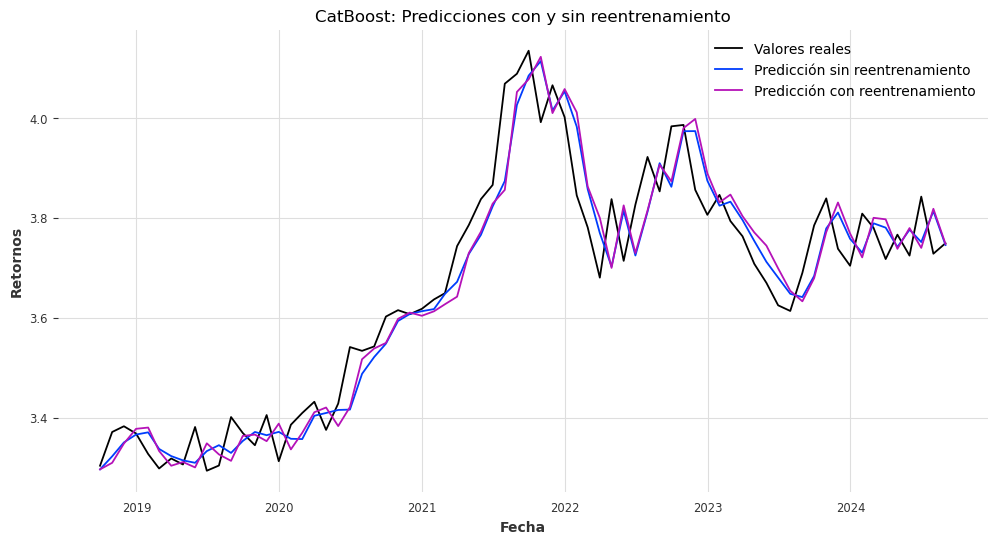

In [214]:
# Visualizar resultados
plt.figure(figsize=(12, 6))
plt.plot(test.time_index, y_true, label='Valores reales')
plt.plot(test.time_index, y_pred_no_retrain, label='Predicción sin reentrenamiento')
plt.plot(test.time_index, y_pred_with_retrain, label='Predicción con reentrenamiento')
plt.legend()
plt.title('CatBoost: Predicciones con y sin reentrenamiento')
plt.xlabel('Fecha')
plt.ylabel('Retornos')
plt.show()

In [215]:
# Implementar estrategia de trading para ambos casos
real_returns = return_series(test.pd_series())
pred_returns_no_retrain = return_series(
    pd.Series(y_pred_no_retrain, index=test.time_index))
pred_returns_with_retrain = return_series(
    pd.Series(y_pred_with_retrain, index=test.time_index))

In [216]:
# Implementar estrategia de trading para ambos casos
strategy_returns_no_retrain = implement_trading_strategy(real_returns, pred_returns_no_retrain)
strategy_returns_with_retrain = implement_trading_strategy(real_returns, pred_returns_with_retrain)

In [217]:
# Calcular retornos acumulados
cumulative_real = calculate_cumulative_return(real_returns)
cumulative_strategy_no_retrain = calculate_cumulative_return(strategy_returns_no_retrain)
cumulative_strategy_with_retrain = calculate_cumulative_return(strategy_returns_with_retrain)

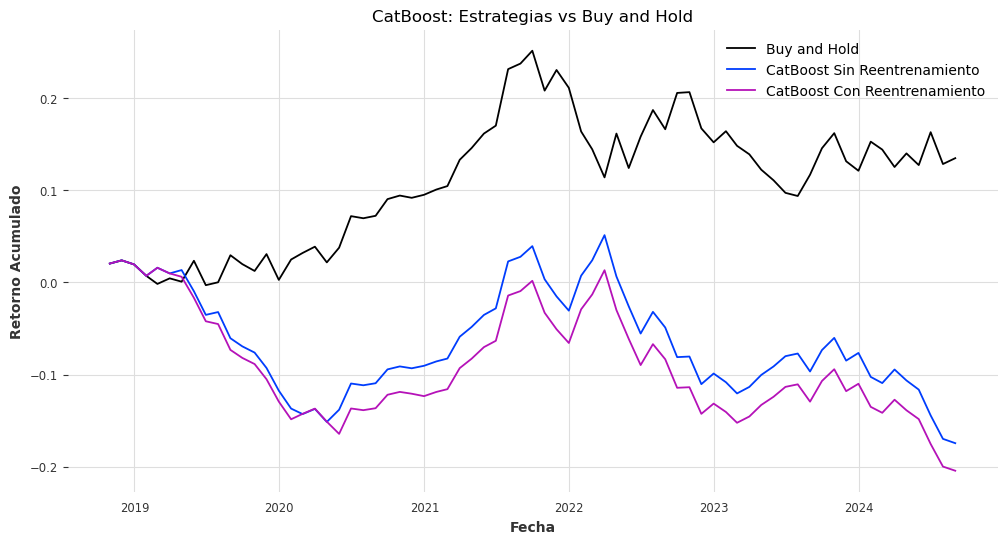

In [218]:
# Visualizar resultados de la estrategia
plt.figure(figsize=(12, 6))
plt.plot(cumulative_real.index, cumulative_real, label='Buy and Hold')
plt.plot(cumulative_strategy_no_retrain.index, cumulative_strategy_no_retrain, label='CatBoost Sin Reentrenamiento')
plt.plot(cumulative_strategy_with_retrain.index, cumulative_strategy_with_retrain, label='CatBoost Con Reentrenamiento')
plt.legend()
plt.title('CatBoost: Estrategias vs Buy and Hold')
plt.xlabel('Fecha')
plt.ylabel('Retorno Acumulado')
plt.show()

In [219]:
# Calcular métricas de rendimiento para ambas estrategias
metrics_buy_hold = calculate_all_metrics(real_returns)
metrics_strategy_no_retrain = calculate_all_metrics(strategy_returns_no_retrain,real_returns)
metrics_strategy_with_retrain = calculate_all_metrics(strategy_returns_with_retrain,real_returns)

print("\nMétricas de rendimiento:")
print("\nBuy and Hold:")
for k, v in metrics_buy_hold.items():
    print(f"{k}: {v:.4f}")
print("\nEstrategia CATBOOST sin reentrenamiento:")
for k, v in metrics_strategy_no_retrain.items():
    print(f"{k}: {v:.4f}")
print("\nEstrategia CATBOOST con reentrenamiento:")
for k, v in metrics_strategy_with_retrain.items():
    print(f"{k}: {v:.4f}")


Métricas de rendimiento:

Buy and Hold:
Total Return: 0.1348
Annualized Return: 0.0216
Sharpe Ratio: 0.3437
Information Ratio: 0.0992
Max Drawdown: -0.1260
Hit Ratio: 100.0000

Estrategia CATBOOST sin reentrenamiento:
Total Return: -0.1745
Annualized Return: -0.0319
Sharpe Ratio: -0.4360
Information Ratio: -0.1685
Max Drawdown: -0.2147
Hit Ratio: 59.1549

Estrategia CATBOOST con reentrenamiento:
Total Return: -0.2043
Annualized Return: -0.0379
Sharpe Ratio: -0.5285
Information Ratio: -0.1872
Max Drawdown: -0.2229
Hit Ratio: 57.7465


In [220]:
# Convertir los valores reales y predicciones a TimeSeries de Darts
y_true_timeseries = TimeSeries.from_series(
    pd.Series(y_true, index=test.time_index))

y_pred_no_retrain_timeseries = TimeSeries.from_series(
    pd.Series(y_pred_no_retrain, index=test.time_index))

y_pred_with_retrain_timeseries = TimeSeries.from_series(
    pd.Series(y_pred_with_retrain, index=test.time_index))

# Ahora podemos usar la función evaluate_model_performance sin modificarla
catboost_metrics_no_retrain, catboost_returns_no_retrain = evaluate_model_performance(
    y_true, y_pred_no_retrain, "CATBOOST", retrain=False)

catboost_metrics_with_retrain, catboost_returns_with_retrain = evaluate_model_performance(
    y_true, y_pred_with_retrain, "CATBOOST", retrain=True)

In [221]:
# Convertir las predicciones de CatBoost a TimeSeries de Darts
catboost_forecast_no_retrain_unscaled = TimeSeries.from_series(
    pd.Series(y_pred_no_retrain, index=test.time_index))

catboost_forecast_with_retrain_unscaled = TimeSeries.from_series(
    pd.Series(y_pred_with_retrain, index=test.time_index))

# TIDEModel

In [222]:
# Preprocesamiento de datos
series = TimeSeries.from_dataframe(df[['PEN']])
train_size = int(len(series) * 0.8)
train, test = series[:train_size], series[train_size:]

scaler = Scaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

In [ ]:
def optimize_tide(train_data):
    
    def objective(trial):
        # Definir los hiperparámetros a optimizar
        params = {
            'input_chunk_length': trial.suggest_int('input_chunk_length', 12, 72),
            'output_chunk_length': 1,  
            'num_encoder_layers': trial.suggest_int('num_encoder_layers', 1, 4),
            'num_decoder_layers': trial.suggest_int('num_decoder_layers', 1, 4),
            'hidden_size': trial.suggest_categorical('hidden_size', [32, 64, 128, 256]),
            'decoder_output_dim': trial.suggest_int('decoder_output_dim', 8, 32),
            'temporal_width_past': trial.suggest_int('temporal_width_past', 2, 8),
            'temporal_width_future': trial.suggest_int('temporal_width_future', 2, 8),
            'temporal_decoder_hidden': trial.suggest_int('temporal_decoder_hidden', 16, 64),
            'use_layer_norm': trial.suggest_categorical('use_layer_norm', [True, False]),
            'dropout': trial.suggest_float('dropout', 0.0, 0.5),
            'batch_size': trial.suggest_categorical('batch_size', [32, 64, 128]),
            'n_epochs': 20,  # Reducido para agilizar la optimización
            'random_state': 42
        }

        # Crear el modelo TiDE con los parámetros sugeridos
        model = TiDEModel(**params)

        # Realizar predicciones históricas para la validación cruzada
        backtest = model.historical_forecasts(
            series=train_data,
            start=train_data.time_index[int(len(train_data) * 0.8)],  # Comenzar en el 80% de la serie
            forecast_horizon=3,  # Predicción de 3 pasos a la vez
            stride=3,  # Desplazamiento de 3 pasos
            retrain=True,  # Reentrenar en cada paso
            verbose=False,  # Silenciar mensajes
            show_warnings=False  # Evitar mostrar warnings
        )

        # Evaluar el error usando MAE
        error = mae(train_data.slice_intersect(backtest), backtest)
        
        return error

    # Configurar el estudio de optimización con Optuna
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=50)  # Optimización reducida a 20 ensayos

    # Obtener los mejores parámetros
    best_params = study.best_params
    best_params['output_chunk_length']= 1
    best_params['n_epochs'] = 100  # Ajuste final de épocas para entrenamiento completo
    best_params['random_state'] = 42
    
    return best_params

In [224]:
def train_tide(train_data):
    loaded_params = load_hyperparameters('tide')
    if loaded_params is None:
        print("Optimizando hiperparámetros para TiDE...")
        best_params = optimize_tide(train_data)
        save_hyperparameters(best_params, 'tide')
    else:
        print("Cargando hiperparámetros guardados para TiDE...")
        best_params = loaded_params
    
    model = TiDEModel(**best_params)
    model.fit(train_data, verbose=False)
    save_model(model, 'tide')
    return model

In [225]:
# Entrenar modelo TiDE
tide_model = train_tide(train_scaled)

Cargando hiperparámetros guardados para TiDE...
Modelo guardado en tide_model.pkl


In [226]:
# Realizar rolling forecast
tide_forecast_no_retrain = step_by_step_forecast(tide_model, train_scaled, test_scaled, retrain=False, model_name='tide')

Cargando forecast guardado de tide_forecast_no_retrain.pkl


In [227]:
tide_forecast_with_retrain = step_by_step_forecast(tide_model, train_scaled, test_scaled, retrain=True, model_name='tide')

Cargando forecast guardado de tide_forecast_retrain.pkl


In [228]:
# Desescalar las predicciones

tide_forecast_no_retrain_unscaled = scaler.inverse_transform(tide_forecast_no_retrain)
tide_forecast_with_retrain_unscaled = scaler.inverse_transform(tide_forecast_with_retrain)

In [229]:
# Evaluar ambos modelos
y_true = test.values().flatten()
y_pred_no_retrain = tide_forecast_no_retrain_unscaled.values().flatten()
y_pred_with_retrain = tide_forecast_with_retrain_unscaled.values().flatten()

tide_evaluation_no_retrain = evaluate_model(y_true, y_pred_no_retrain)
tide_evaluation_with_retrain = evaluate_model(y_true, y_pred_with_retrain)

print("Evaluación del modelo TiDE sin reentrenamiento:")
for metric, value in tide_evaluation_no_retrain.items():
    print(f"{metric}: {value:.6f}")

print("\nEvaluación del modelo TiDE con reentrenamiento:")
for metric, value in tide_evaluation_with_retrain.items():
    print(f"{metric}: {value:.6f}")

Evaluación del modelo TiDE sin reentrenamiento:
MSE: 0.013365
RMSE: 0.115608
MAE: 0.090797
R2: 0.745703

Evaluación del modelo TiDE con reentrenamiento:
MSE: 0.009344
RMSE: 0.096666
MAE: 0.074782
R2: 0.822209


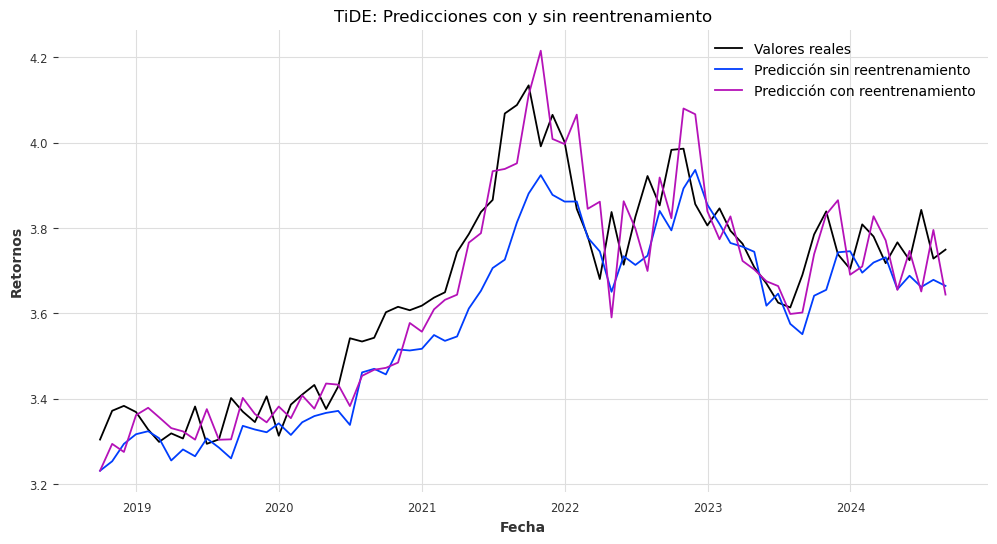

In [230]:
# Visualizar resultados
plt.figure(figsize=(12, 6))
plt.plot(test.time_index,y_true,label='Valores reales')
plt.plot(test.time_index,y_pred_no_retrain,label='Predicción sin reentrenamiento')
plt.plot(test.time_index,y_pred_with_retrain,label='Predicción con reentrenamiento')
plt.legend()
plt.title('TiDE: Predicciones con y sin reentrenamiento')
plt.xlabel('Fecha')
plt.ylabel('Retornos')
plt.show()

In [231]:
# Implementar estrategia de trading para ambos casos
real_returns = return_series(test.pd_series())
pred_returns_no_retrain = return_series(tide_forecast_no_retrain_unscaled.pd_series())
pred_returns_with_retrain = return_series(tide_forecast_with_retrain_unscaled.pd_series())

In [232]:
# Implementar estrategia de trading para ambos casos
strategy_returns_no_retrain = implement_trading_strategy(real_returns, pred_returns_no_retrain)
strategy_returns_with_retrain = implement_trading_strategy(real_returns, pred_returns_with_retrain)

In [233]:
# Calcular retornos acumulados
cumulative_real = calculate_cumulative_return(real_returns)
cumulative_strategy_no_retrain = calculate_cumulative_return(strategy_returns_no_retrain)
cumulative_strategy_with_retrain = calculate_cumulative_return(strategy_returns_with_retrain)

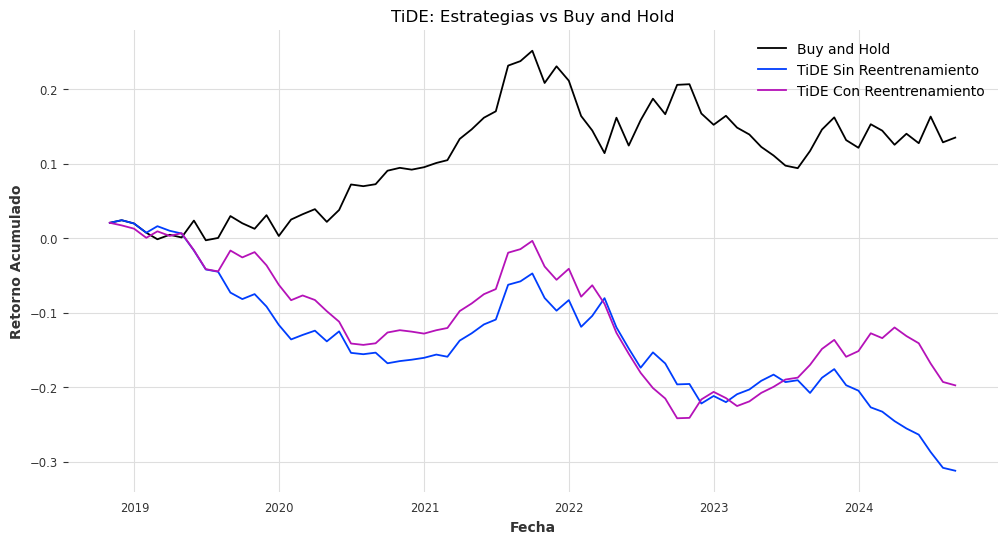

In [234]:
# Visualizar resultados de la estrategia
plt.figure(figsize=(12, 6))
plt.plot(cumulative_real.index, cumulative_real, label='Buy and Hold')
plt.plot(cumulative_strategy_no_retrain.index, cumulative_strategy_no_retrain, label='TiDE Sin Reentrenamiento')
plt.plot(cumulative_strategy_with_retrain.index, cumulative_strategy_with_retrain, label='TiDE Con Reentrenamiento')
plt.legend()
plt.title('TiDE: Estrategias vs Buy and Hold')
plt.xlabel('Fecha')
plt.ylabel('Retorno Acumulado')
plt.show()

In [235]:
# Calcular métricas de rendimiento para ambas estrategias
metrics_buy_hold = calculate_all_metrics(real_returns)
metrics_strategy_no_retrain = calculate_all_metrics(strategy_returns_no_retrain,real_returns)
metrics_strategy_with_retrain = calculate_all_metrics(strategy_returns_with_retrain,real_returns)

print("\nMétricas de rendimiento:")
print("\nBuy and Hold:")
for k, v in metrics_buy_hold.items():
    print(f"{k}: {v:.4f}" if isinstance(v, float) else f"{k}: {v}")
print("\nEstrategia TiDE sin reentrenamiento:")
for k, v in metrics_strategy_no_retrain.items():
    print(f"{k}: {v:.4f}" if isinstance(v, float) else f"{k}: {v}")
print("\nEstrategia TiDE con reentrenamiento:")
for k, v in metrics_strategy_with_retrain.items():
    print(f"{k}: {v:.4f}" if isinstance(v, float) else f"{k}: {v}")


Métricas de rendimiento:

Buy and Hold:
Total Return: 0.1348
Annualized Return: 0.0216
Sharpe Ratio: 0.3437
Information Ratio: 0.0992
Max Drawdown: -0.1260
Hit Ratio: 100.0000

Estrategia TiDE sin reentrenamiento:
Total Return: -0.3123
Annualized Return: -0.0613
Sharpe Ratio: -0.9072
Information Ratio: -0.2735
Max Drawdown: -0.3283
Hit Ratio: 56.3380

Estrategia TiDE con reentrenamiento:
Total Return: -0.1977
Annualized Return: -0.0365
Sharpe Ratio: -0.5075
Information Ratio: -0.1920
Max Drawdown: -0.2570
Hit Ratio: 53.5211


In [236]:
# Ejemplo para NBEATS
tide_metrics_no_retrain, tide_returns_no_retrain = evaluate_model_performance(
    y_true, y_pred_no_retrain, "TIDE", retrain=False)
tide_metrics_with_retrain, tide_returns_with_retrain = evaluate_model_performance(
    y_true, y_pred_with_retrain, "TIDE", retrain=True)